In [4]:
import numpy as np 
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import Binarizer, binarize
from copy import copy
from collections import Counter
import matplotlib.pyplot as plt 

# import counter
data_digits, label_digits = datasets.load_digits(return_X_y=True)
PCA_COMP =8
pca = PCA(n_components= PCA_COMP)

data_digits_reduced = pca.fit_transform(data_digits)

def mean_threshold_binarization(dat_):
    dat = copy(dat_)
    dat_mean = dat.mean()
    dat[dat >= dat_mean] = int(1) 
    dat[dat < dat_mean] = int(0)
    return dat 

to_bin = lambda data : ''.join(map(str, map(int, binarize([data], threshold= data.mean()).tolist()[0] )) )
data_digits_bin = [ to_bin(data) for data in data_digits_reduced ] 
# training_data = list(zip(data_digits_bin, label_digits))
from qumcmc.prob_dist import DiscreteProbabilityDistribution
from qumcmc.training import CDTraining
from qumcmc.energy_models import IsingEnergyFunction, random_ising_model, Exact_Sampling
from qumcmc.mcmc_sampler_base import MCMCSampler, QuantumMCMCSampler, ClassicalMCMCSampler
from qumcmc.classical_mixers import *
from qumcmc.mixers import *
from qumcmc.basic_utils import *

cal_gradvar = lambda TRAINING0 : [ (max(b[1]+b[0]), min(b[1]+b[0])) for b in TRAINING0.training_history['max-min-gradient'] ]

In [5]:
nspin = PCA_COMP
seed = 142248787
DATA = DiscreteProbabilityDistribution(Counter(data_digits_bin))
MODEL0 = random_ising_model(nspin, seed,)
MODEL0S = Exact_Sampling(MODEL0)
BETA0= 1.0

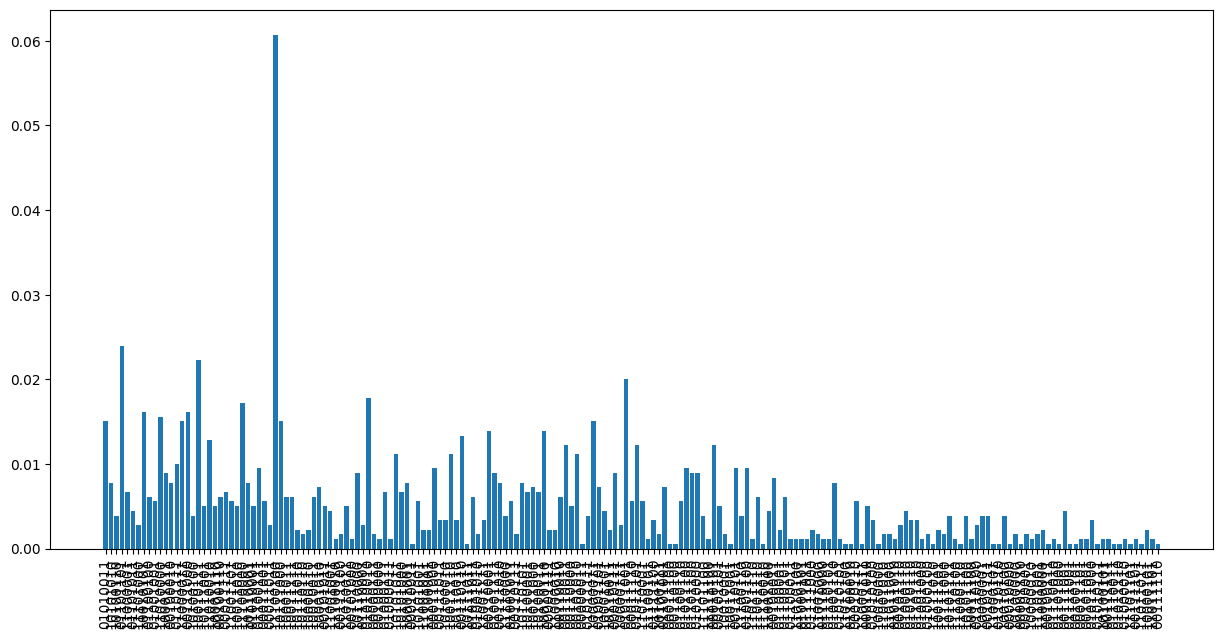

In [6]:
plt.figure(figsize=(15,7))
plot_bargraph_desc_order(DATA)

In [7]:
CLSMIXER_UNIFORM = UniformProposals(nspin)
CLSAMPLER0 = ClassicalMCMCSampler(10, MODEL0, CLSMIXER_UNIFORM, name= 'CLSAMPLER0')

QMIXER_GENERIC = GenericMixer(nspin, int(nspin/2))
QSAMPLER0 = QuantumMCMCSampler(10, MODEL0, QMIXER_GENERIC, gamma= 0.5, verbose= False, name= 'QSAMPLER0')



### ---

In [8]:


TRAINING0 = CDTraining(MODEL0, BETA0, DATA, name= 'mnist-v0')
TRAINING1 = CDTraining(MODEL0, BETA0, DATA, name= 'mnist-v1')

In [9]:
TRAINING0.train(QSAMPLER0, 1000, epochs= 2000, verbose= True)

training epochs:   0%|          | 3/2000 [00:07<1:19:15,  2.38s/it, sampler=QSAMPLER0, update-strategy=all, kl div =2.95]


KeyboardInterrupt: 

In [ ]:
TRAINING1.train(CLSAMPLER0, 1000, epochs= 2000, verbose= True)

training epochs: 100%|██████████| 2000/2000 [01:42<00:00, 19.43it/s, sampler=CLSAMPLER0, update-strategy=all, kl div =0.533]


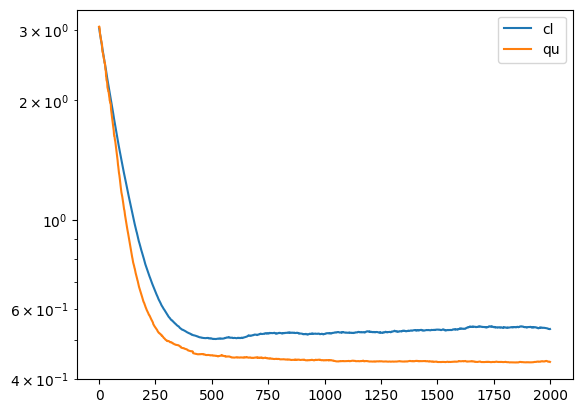

In [ ]:
plt.plot(TRAINING1.training_history['kl_div'], label= 'cl')#, TRAINING0.training_history['kl_div'])
plt.plot(TRAINING0.training_history['kl_div'], label= 'qu')#, TRAINING0.training_history['kl_div'])
plt.yscale('log')
plt.legend()


2.6347705194555457

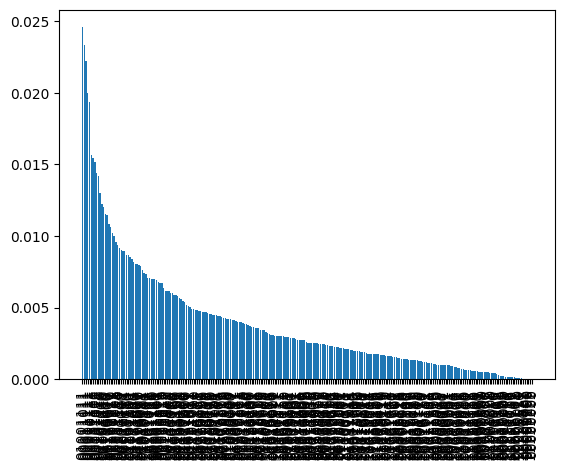

In [ ]:
training1model = Exact_Sampling(TRAINING1.model)
plot_bargraph_desc_order(training1model.boltzmann_pd)

kl_divergence(training1model.boltzmann_pd, MODEL0S.boltzmann_pd)

2.55340644474934

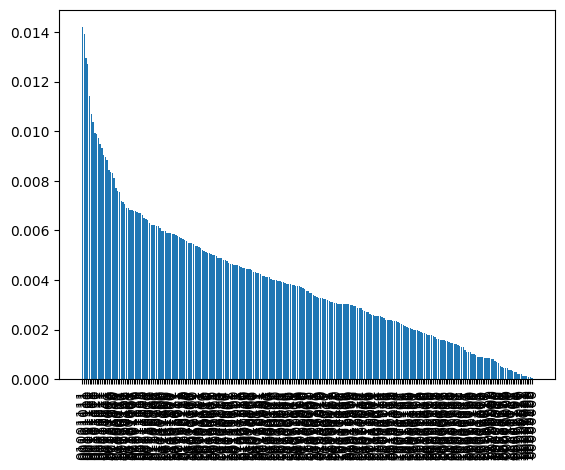

In [ ]:
training0model = Exact_Sampling(TRAINING0.model)
plot_bargraph_desc_order(training0model.boltzmann_pd)

kl_divergence(training0model.boltzmann_pd, MODEL0S.boltzmann_pd)

###  --- 

In [8]:
NUM_TRAININIG_RUNS = 10

rmodels = [random_ising_model(nspin, seed= np.random.randint(100,10000)) for k in range(NUM_TRAININIG_RUNS)]
CTRAIN = [ CDTraining(model, BETA0, DATA, name= f"Ct{k}", pickle_loc= f"Ct{k}.pkl") for k,model in enumerate(rmodels) ]
QTRAIN = [ CDTraining(model, BETA0, DATA, name= f"Qt{k}", pickle_loc= f"Qt{k}.pkl") for k,model in enumerate(rmodels) ]


In [9]:
for training_model in CTRAIN : 
    training_model.train(CLSAMPLER0, 1000, epochs= 2000, verbose= True, save_picle=True)
for training_model in QTRAIN : 
    training_model.train(QSAMPLER0, 1000, epochs= 2000, verbose= True, save_picle= True)


training epochs:  37%|███▋      | 747/2000 [23:39<42:54,  2.05s/it, sampler=QSAMPLER0, update-strategy=all, kl div =0.454] 

### ---

In [21]:
import pickle as pkl

pklfileloc= ''
pklfilename= 'mnist-v0-qu.pkl'
pklfile = pklfileloc+pklfilename

with open(pklfile, 'wb') as f :
    pkl.dump(TRAINING0, f)

pklfileloc= ''
pklfilename= 'mnist-v0-cl.pkl'
pklfile = pklfileloc+pklfilename

with open(pklfile, 'wb') as f :
    pkl.dump(TRAINING1, f)


In [10]:
TRAINING0.model == MODEL0

False